# Imports and Setup

In [1]:
!git clone https://github.com/ayulockin/happywhale_kaggle

Cloning into 'happywhale_kaggle'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 19), reused 26 (delta 9), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [2]:
!pip install -qq efficientnet
!pip install -qq tensorflow_addons

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

print(tf.__version__)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
 IS_COLAB = not os.path.exists('/kaggle/input')
print("Using Colab: ", IS_COLAB)

if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

Using Colab:  False


In [5]:
import re
import math
import json
import pickle
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

import tensorflow_hub as tfhub
import tensorflow_addons as tfa

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

from happywhale_kaggle.utils import id_generator

In [6]:
import wandb
print(wandb.__version__)
from wandb.keras import WandbCallback

if not IS_COLAB:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("wandb_api")
    wandb.login(key=secret_value_0)
else:
    wandb.login()

0.12.2


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Utils

In [7]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

False


## Config

In [8]:
class config:
    SEED = 42
    FOLD_TO_RUN = 0
    FOLDS = 5
    DEBUG = True
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    ### Dataset
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 512
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'
    EFF_NET = 5
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface'
    EPOCHS = 30
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Inference
    KNN = 50
    
    # Exp id for W&B
    EXP_ID = id_generator(size=8)
    
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)
    
wandb_config = {key:value for key, value in config.__dict__.items() if not key.startswith('__') and not callable(key)}

effnetv1_b5


# Get Dataset

In [9]:
GCS_PATH = 'gs://kds-d916c3252bf3bc5b3500b904f05f51ce57c8df85221d11b7711bcda9'
if not IS_COLAB:
    GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files), len(test_files), count_data_items(train_files), count_data_items(test_files))

gs://kds-b46d677ea558a164a3759b4081e497c09d42367357c6cc76bd802624
10 10 51033 27956


# Data Loader

In [10]:
train_df = pd.read_csv('../input/happywhale-splits/skf_species_10folds.csv')
train_df.head()

image  species  individual_id  fold
0  00021adfb725ed.jpg        0              0   0.0
1  000562241d384d.jpg        1              1   0.0
2  0007c33415ce37.jpg        2              2   0.0
3  0007d9bca26a99.jpg        3              3   0.0
4  00087baf5cef7a.jpg        1              4   0.0

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image, posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image, label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):
    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name'] # NAME OF THE IMAGE
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32) # ACTUAL TARGET
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Sanity Check

51033


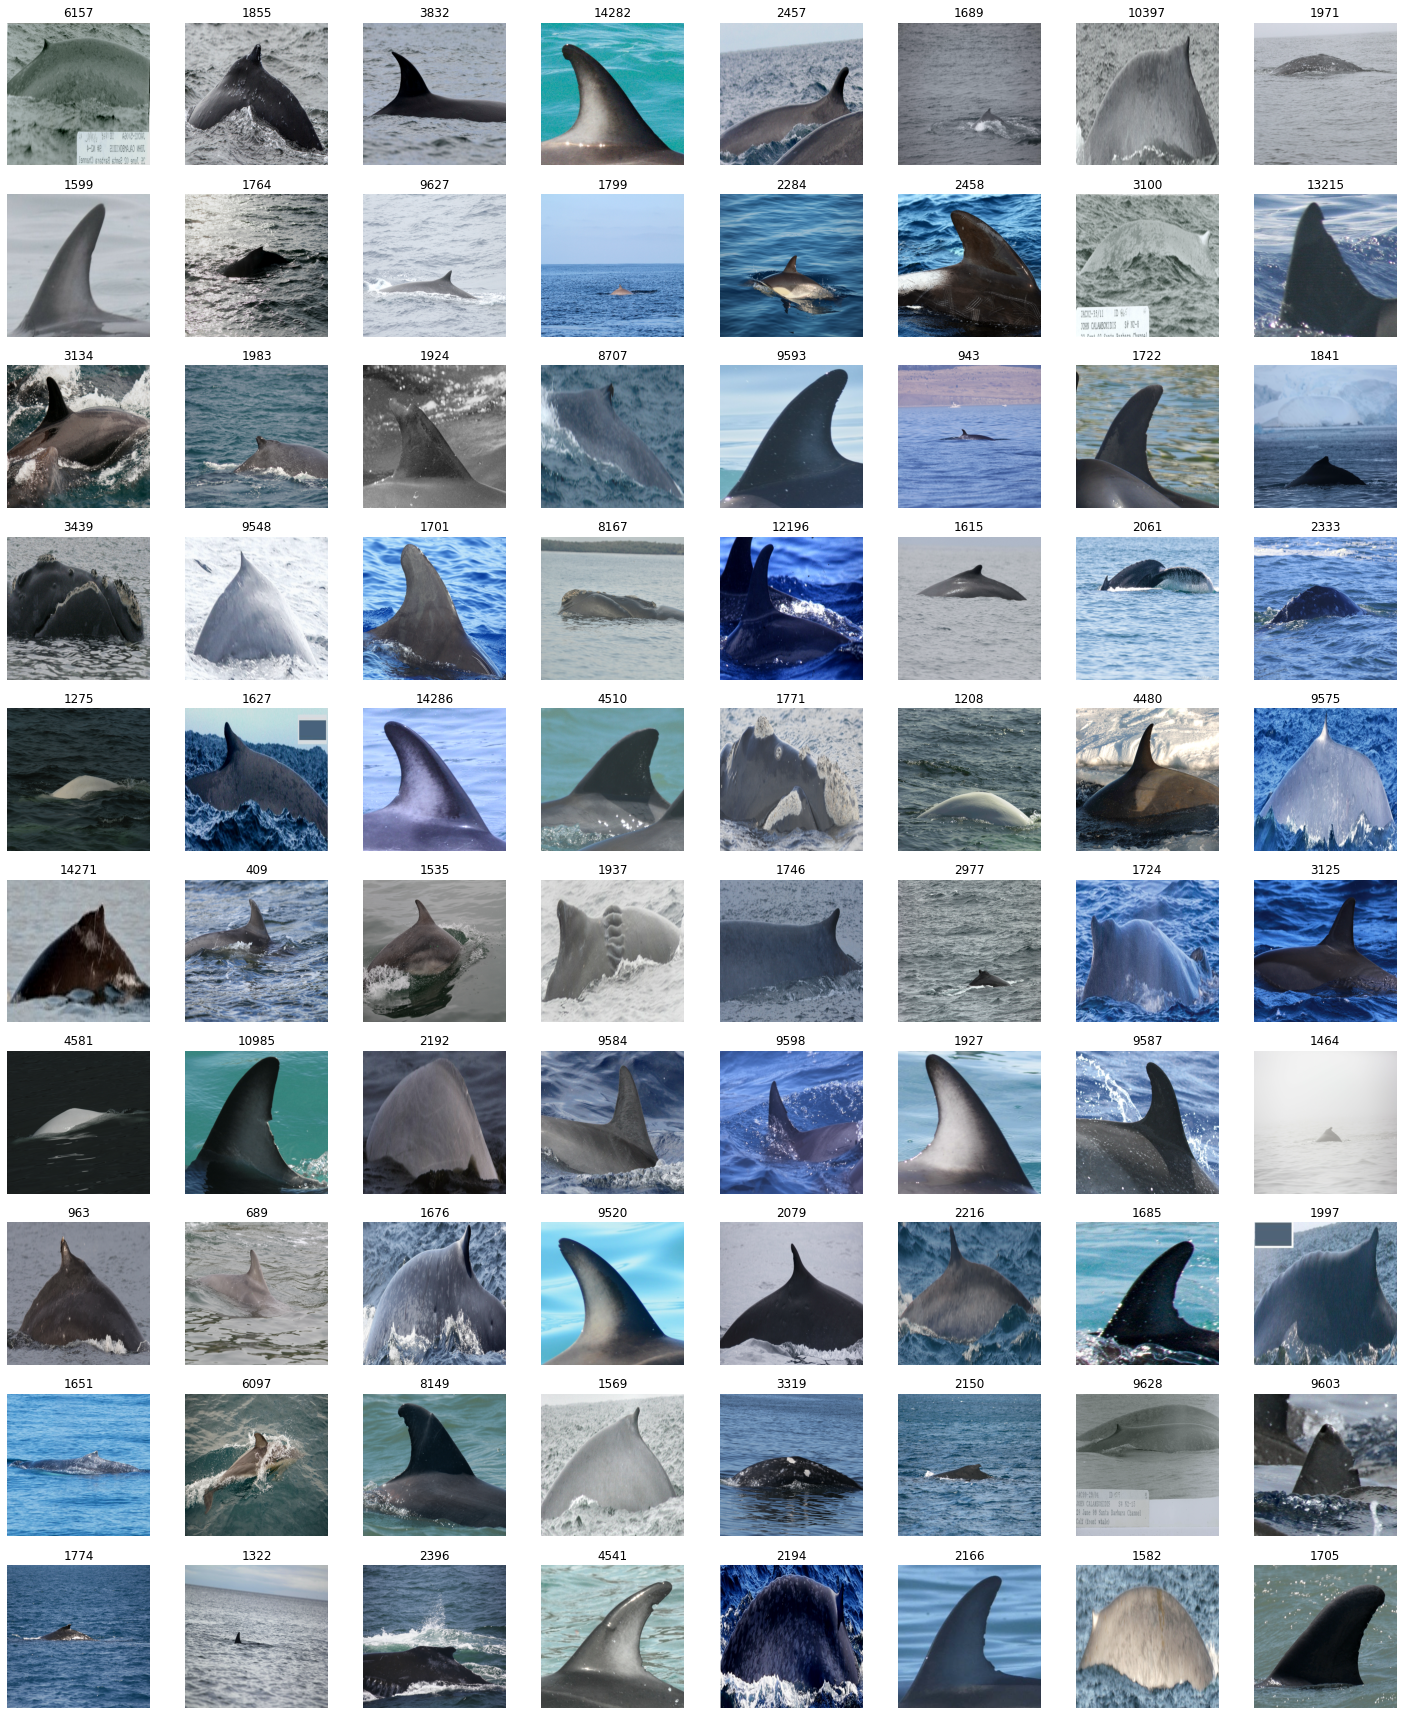

(256, 512, 512, 3)


In [12]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

27956


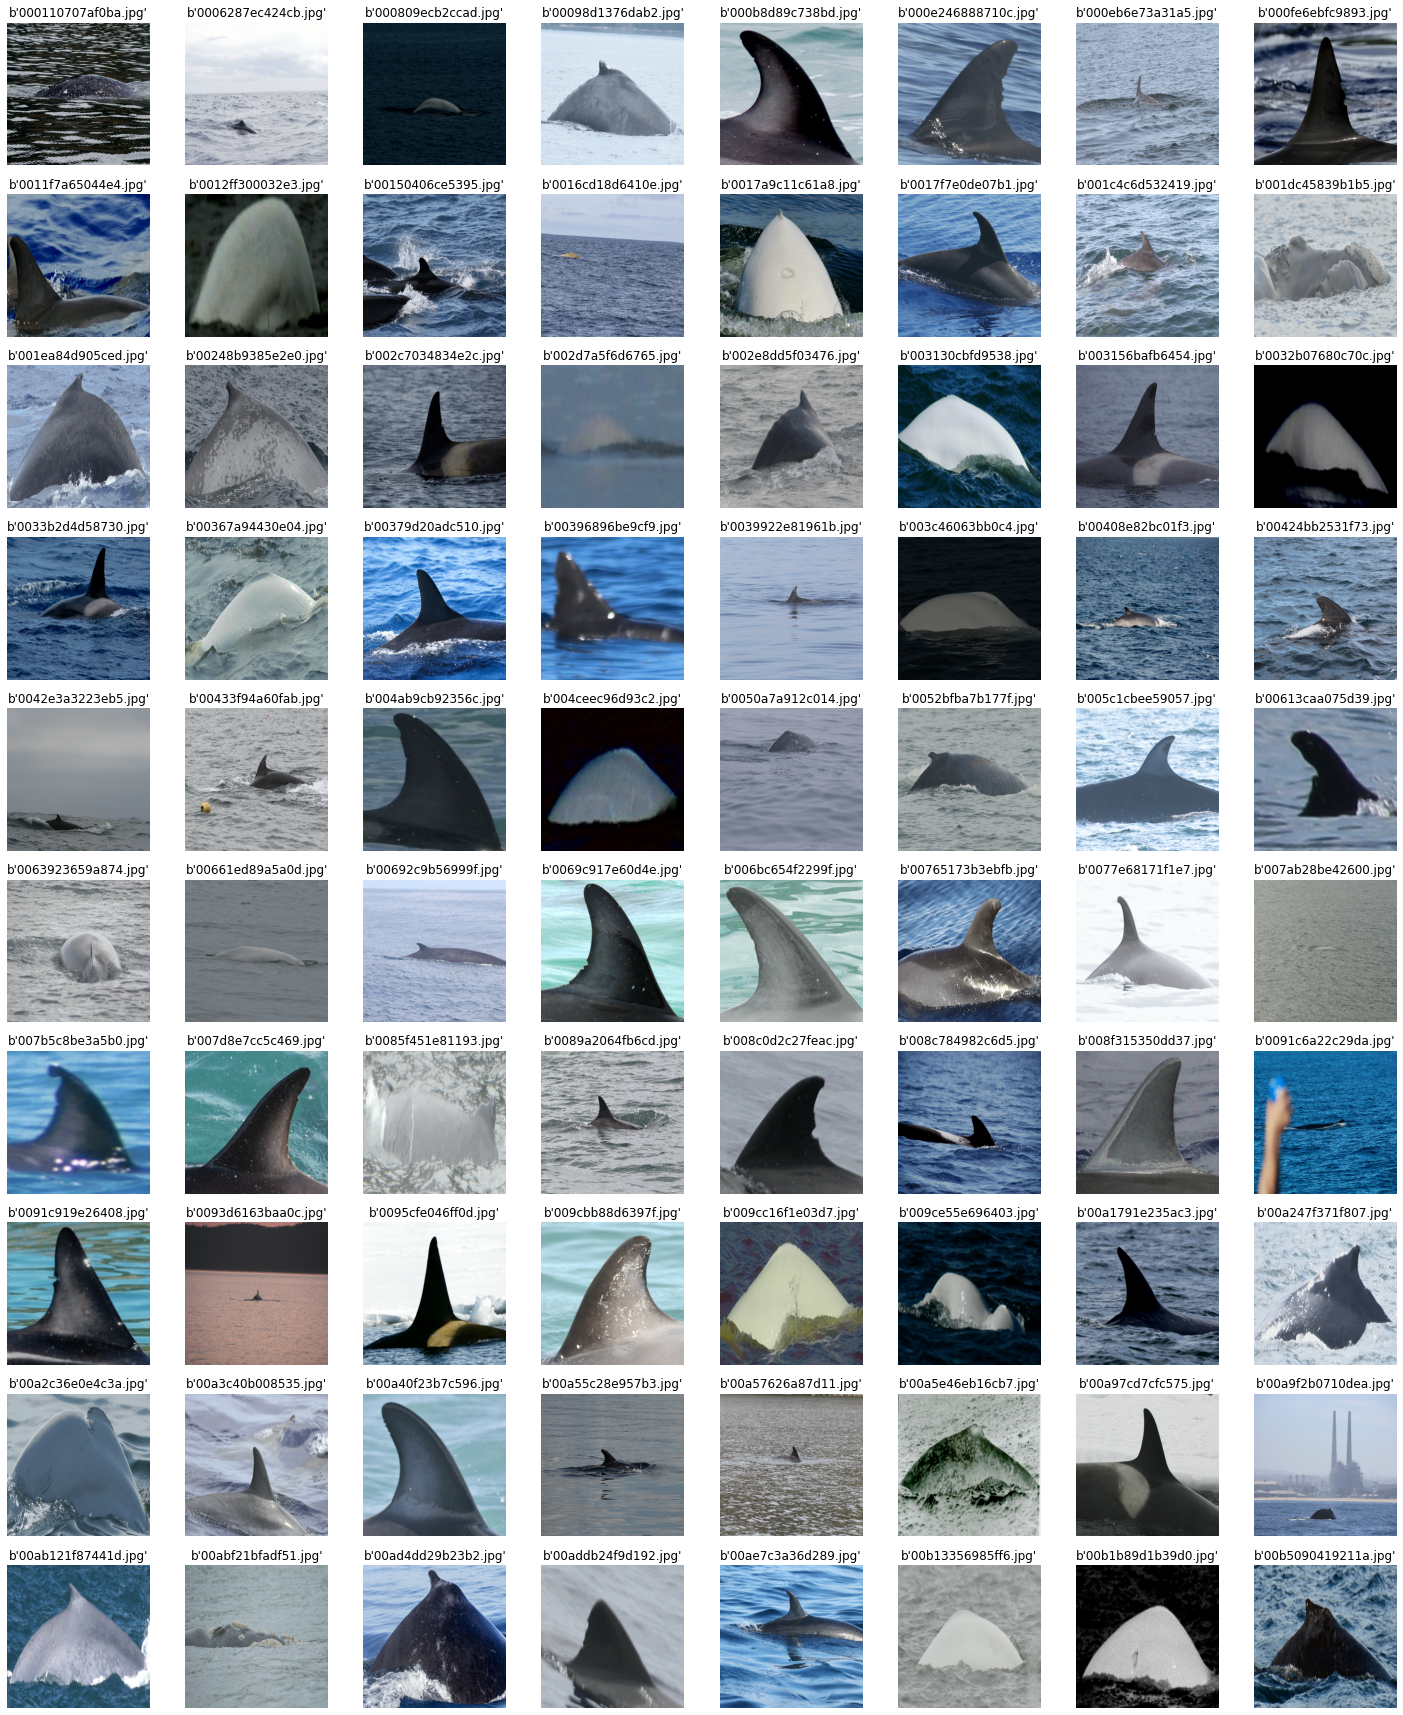

(256, 512, 512, 3)


In [13]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
print(img.shape)

# Model

In [14]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [15]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30,
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )

        inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
            
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model, embed_model

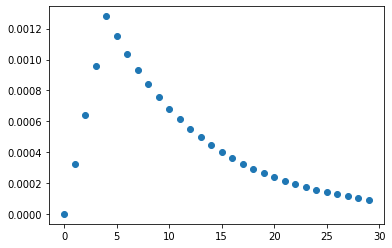

In [16]:
def get_lr_callback(plot=False, use_wandb=True):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        # log the current learning rate onto W&B
        if use_wandb:
            if wandb.run is None:
                raise wandb.Error("You must call wandb.init() before WandbCallback()")

            wandb.log({'learning_rate': lr}, commit=False)
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True, use_wandb=False)

# Callbacks

In [17]:
!rm -rf models
os.makedirs('models', exist_ok=True)
def model_ckpt_callback(fold):
    return tf.keras.callbacks.ModelCheckpoint(
        f"models/{config.MODEL_NAME}_{fold}.h5",
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        save_freq='epoch')

# Train

In [18]:
for fold in range(config.FOLDS):
    print('#### Image Size %i with EfficientNet B%i and batch_size %i for fold %i' %
          (config.IMAGE_SIZE, config.EFF_NET, config.BATCH_SIZE, fold+1))
    # Seed
    seed_everything(config.SEED)
    # Get the dataset
    TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=fold]
    VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==fold]
    # Get the dataloader
    train_dataset = get_training_dataset(TRAINING_FILENAMES)
    val_dataset = get_val_dataset(VALIDATION_FILENAMES)
    STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
    # Get the model
    tf.keras.backend.clear_session()
    model, embed_model = get_model()
    # Get callbacks
    model_ckpt = model_ckpt_callback(fold)
    # Initialize W&B run
    run = wandb.init(project='happywhale',
                     config=wandb_config,
                     group=f'{MODEL_NAME}-{config.EXP_ID}',
                     job_type='train-tpu',
                     name=f'{config.EXP_ID}_{fold}_train')
    # Train
    _ = model.fit(train_dataset,
                  validation_data=val_dataset,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=config.EPOCHS,
                  callbacks=[get_lr_callback(),
                             WandbCallback(save_model=False),
                             model_ckpt])
    # End the W&B run
    wandb.finish()
    break

#### Image Size 512 with EfficientNet B5 and batch_size 256 for fold 1
115261440/115255328 [==============================] - 1s 0us/step


wandb: Currently logged in as: ayush-thakur (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Epoch 1/30
159/159 [==============================] - 383s 2s/step - loss: 19.3727 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 19.3884 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 2/30
159/159 [==============================] - 202s 1s/step - loss: 18.3747 - sparse_categorical_accuracy: 4.5224e-06 - sparse_top_k_categorical_accuracy: 7.4919e-06 - val_loss: 16.9000 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 6.8580e-04
Epoch 3/30
159/159 [==============================] - 204s 1s/step - loss: 16.3369 - sparse_categorical_accuracy: 2.1682e-04 - sparse_top_k_categorical_accuracy: 6.8221e-04 - val_loss: 16.2636 - val_sparse_categorical_accuracy: 0.0105 - val_sparse_top_k_categorical_accuracy: 0.0189
Epoch 4/30
159/159 [==============================] - 204s 1s/step - loss: 14.0056 - sparse_categorical_accuracy: 0.0032 - sparse_top_k

E0224 00:21:31.317705844    1726 backup_poller.cc:118]       run_poller: {"created":"@1645662091.317605912","description":"Shutting down timer system","file":"external/com_github_grpc_grpc/src/core/lib/iomgr/timer_generic.cc","file_line":706}


159/159 [==============================] - 202s 1s/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9894 - sparse_top_k_categorical_accuracy: 0.9992 - val_loss: 11.6942 - val_sparse_categorical_accuracy: 0.2299 - val_sparse_top_k_categorical_accuracy: 0.3030


# Save the model as Artifacts

In [19]:
run = wandb.init(project='happywhale',
                     config=wandb_config,
                     group=f'{MODEL_NAME}-{config.EXP_ID}',
                     job_type='train-tpu',
                     name=f'{config.EXP_ID}_model_ckpts')

model_artifact = wandb.Artifact(f"{config.EXP_ID}-model", "model")
model_artifact.add_dir("models")
run.log_artifact(model_artifact)
wandb.finish()

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Adding directory to artifact (./models)... Done. 6.1s



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



# Evaluation

In [20]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename], get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('../input/happywhale-splits/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [21]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)
train_embeddings.shape, train_targets.shape

  0%|          | 0/8 [00:00<?, ?it/s]

((40826, 512), (40826,))

In [22]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=50)

In [23]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances) # how far
test_nn_idxs = np.concatenate(test_nn_idxs) # where to look for
test_ids = np.concatenate(test_ids) # image names
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets) # actual validation targets

  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    2177
37c7aba965a5        79
114207cab555        40
e69d5f9f8d1e        33
ffbb4e585ff2        32
                  ... 
80f4e0d635a7         1
c3dad9e679f3         1
179af04b755d         1
b7065da154c5         1
5c0572fe9fc1         1
Name: target, Length: 3255, dtype: int64

In [25]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10207 [00:00<?, ?it/s]

1     1218
7      318
4      315
3      311
5      307
2      294
8      287
6      286
9      259
10     259
15     259
12     255
14     245
11     243
13     230
16     228
17     228
18     227
19     224
20     209
23     203
24     195
22     193
25     185
28     176
36     173
38     170
27     169
21     169
37     166
26     165
39     162
35     159
30     159
29     158
34     150
40     149
41     143
32     142
33     140
31     139
42     110
43     100
44      76
45      73
46      57
47      52
48      40
49      21
50      11
Name: image, dtype: int64

In [26]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.0: 0.5846755494595173


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.1: 0.5846755494595173


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.2: 0.5846755494595173


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.5846755494595173


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.4: 0.584773521439531


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.5: 0.6121077038633571


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.6537947813591927


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.6231295516149002


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.8: 0.5738986316580086


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 0.9: 0.5222184122007743


0it [00:00, ?it/s]

  0%|          | 0/10207 [00:00<?, ?it/s]

CV at threshold 1.0: 0.4653946637928201


In [27]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.6000000000000001
Best cv 0.6537947813591927


0.0           0.1           0.2  0.30000000000000004  \
count  10207.000000  10207.000000  10207.000000         10207.000000   
mean       0.584676      0.584676      0.584676             0.584676   
std        0.413539      0.413539      0.413539             0.413539   
min        0.000000      0.000000      0.000000             0.000000   
25%        0.200000      0.200000      0.200000             0.200000   
50%        0.500000      0.500000      0.500000             0.500000   
75%        1.000000      1.000000      1.000000             1.000000   
max        1.000000      1.000000      1.000000             1.000000   

                0.4           0.5  0.6000000000000001  0.7000000000000001  \
count  10207.000000  10207.000000        10207.000000        10207.000000   
mean       0.584774      0.612108            0.653795            0.623130   
std        0.413578      0.423477            0.434848            0.426909   
min        0.000000      0.000000            0.000000            0.000000   
25%        0.200000      0.200000            0.200000            0.200000   
50%        0.500000      1.000000            1.000000            1.000000   
75%        1.000000      1.000000            1.000000            1.000000   
max        1.000000      1.000000            1.000000            1.000000   

                0.8           0.9           1.0  
count  10207.000000  10207.000000  10207.000000  
mean       0.573899      0.522218      0.465395  
std        0.409065      0.382700      0.342551  
min        0.000000      0.000000      0.000000  
25%        0.200000      0.200000      0.200000  
50%        0.500000      0.500000      0.500000  
75%        1.000000      1.000000      0.500000  
max        1.000000      1.000000      1.000000

In [28]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8030, True: 2177}
best_threshold 0.6000000000000001


is_new_individual       False      True  adjusted_cv
0.0                  0.607632  0.500000     0.596869
0.1                  0.607632  0.500000     0.596869
0.2                  0.607632  0.500000     0.596869
0.30000000000000004  0.607632  0.500000     0.596869
0.4                  0.607632  0.500459     0.596915
0.5                  0.605826  0.635278     0.608771
0.6000000000000001   0.579425  0.928112     0.614294
0.7000000000000001   0.523198  0.991732     0.570052
0.8                  0.458690  0.998852     0.512706
0.9                  0.392688  1.000000     0.453419
1.0                  0.320459  1.000000     0.388413

## Inference

In [29]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 512) (51033,)


In [30]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=50)

In [31]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
sample_submission = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))

27956 27956


In [33]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.image.value_counts()

  0%|          | 0/27956 [00:00<?, ?it/s]

360f61890d44db.jpg    50
0f9e198a3fcae7.jpg    50
a8aab3f17f525e.jpg    50
429c9b352905cd.jpg    50
07ef6654895c58.jpg    50
                      ..
f5634e4688be19.jpg     1
0956843d91a22d.jpg     1
0ab9dcb1beec28.jpg     1
c5b503e492eb9d.jpg     1
5fb61ff7e07076.jpg     1
Name: image, Length: 27956, dtype: int64

In [34]:
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

1     1084
20     765
14     764
18     764
17     760
16     739
21     738
15     732
19     719
24     716
23     705
22     702
27     687
13     682
11     678
10     669
25     665
12     647
26     637
9      636
8      629
7      599
28     585
29     584
30     580
31     566
6      550
32     548
4      546
5      544
36     543
33     536
2      536
38     522
3      505
35     495
34     493
37     483
39     477
41     436
40     434
43     403
42     395
44     354
45     306
46     238
47     223
48     170
49     124
50      63
Name: image, dtype: int64

In [35]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [36]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):# all possible
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted: 
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

0it [00:00, ?it/s]

In [37]:
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

  0%|          | 0/27956 [00:00<?, ?it/s]

image                                        predictions
0  5fb61ff7e07076.jpg  2e0b381d3467 new_individual 938b7e931166 5bf17...
1  561dd86fc30030.jpg  4a67e64bd3b7 new_individual 938b7e931166 5bf17...
2  9d0a9ee1350f37.jpg  de4177f4fd05 new_individual 938b7e931166 5bf17...
3  50df0a954eb94c.jpg  713eb1a00c3d new_individual f664abace56d b848a...
4  3c52966f74d2ad.jpg  978520860ceb new_individual cfd34e95a962 02399...